# Spectrograms

**Topic:**
* Spectrograms

**Learning Objectives:**
* Understand how window length $N$ time- and frequency resolution for spectrograms/real-time frequency analysis
* Understand how window functions affect spectrograms/real-time frequency analysis
* Gain practical experience with tweaking various parameters for spectrograms/real-time frequency analysis

**Libraries and Notebook config:**

In [1]:
from numpy import sin, cos, pi, exp, empty, mean, absolute, angle # Sentrale matematiske funksjoner
from numpy.fft import fft, ifft             # DFT og IDFT
import numpy as np                          # Importer funksjonalitet fra numpy biblioteket med prefiks "np"
import matplotlib.pyplot as plt             # Importer pyplot modulen i matplotlib med prefiks "plt"
import scipy.signal.windows as win          # Importerer funksjonalitet for å generere en rekke vindusfunksjoner
from scipy.io import loadmat, savemat, wavfile               # Lesing av data fra '.mat' fil
from scipy.signal import spectrogram        # Lar oss generere et spektrogram som analyserer et signal i tid og frekvens

%matplotlib ipympl


# Problem Description: Condition Monitoring in Machinery

A wind turbine manufacturer is experiencing challenges with worn bearings at the contact point of one of the shafts in the wind turbines. Specifically, damage to the balls due to wear has been a recurring issue during troubleshooting of the turbines. 

The manufacturer wishes to monitor the condition of the relevant bearing in the wind turbine using a vibration sensor. This sensor will be placed on the outside of the bearing, and a small computer will analyze the signal from the sensor to detect signs of wear as early as possible.

<!--
In lab exercise 2, we utilized the frequency-shifting properties of signal mixing to determine the presence of a specific frequency component in a signal. The signal was obtained from a vibration sensor that measured vibrations in a bearing at a contact point in a wind turbine, where strong vibrations at a specific frequency would indicate that a ball in the bearing was damaged.

We will now look at a similar scenario where a drive shaft transmits power from an electric motor to the propeller on a boat. A vibration sensor is used to detect vibrations in a bearing connected to the shaft, where the shaft's radius is 3.1 times larger than the radius of the balls.-->

![Illustration of a damaged bearing](Figurer/Kulelager.png)

In such a system, under normal circumstances, we expect the vibrations to be composed of harmonics of the rotational speed. This means that if the shaft has a rotational speed $ \rho $ revolutions per second, a frequency analysis of the signal from the vibration sensor will show distinct peaks at integer multiples of the rotational speed $ f \in \{ 1\cdot \rho,\ 2\cdot \rho,\ 3\cdot \rho,\ \ldots\} $.

If damage occurs on one of the balls in the bearing, the produced vibrations will *additionally* contain frequency components that are harmonics of the ball's rotational speed, which is $ 3.1\cdot \rho $. Therefore, a frequency analysis of the signal from the vibration sensor should show distinct peaks at frequencies $ f \in \{ 3.1\cdot \rho,\ 6.2 \cdot \rho,\ 9.3\cdot \rho,\ \ldots \} $ if there is damage to one of the balls. The figure below shows how the frequency content of a signal from a damaged bearing might look if the rotational speed $\rho = 10 $ revolutions per second.

<img src="Figurer/Oppg4_skadeeksempel.png" style="width: 80%" />

From the figure, we can see that the areas in the frequency spectrum of interest for detecting damage in the bearing are close to the areas where normal vibrations would show up. In other words, it is important that the frequency analysis uses window length $ N $ large enough to distinguish between frequency content expected during normal operation, and frequency components that indicate damage.

Unfortunately, there is another detail in this system that can create problems when analyzing the vibration signal. The shaft does not have a constant rotational speed but varies over time. This introduces a new challenge in the frequency analysis since analyzing $ N $ signal samples shows **all** the frequency content within a time period lasting $ \Delta t = N\cdot T_s $, and if the signal's frequency content changes over time, it means we will capture more frequencies the longer the window length $ N $ we use. In other words, to accurately determine the frequency of a pure sinusoidal signal, the signal must be observed for a long time. This is a good example of the [uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle#Harmonic_analysis), which is often associated with quantum mechanics. [Here](https://www.youtube.com/watch?v=MBnnXbOM5S4) is an interesting video that explains the relevance of the uncertainty principle in signal processing.

The audio file `Oppgave4.wav` contains a log of the vibration signal from a simulated bearing that broke down. You can load the signal samples and sampling frequency by running the code cell below. We will now try to calibrate various parameters for the frequency analysis so that we can identify the presence of a bearing defect as early as possible. To analyze the frequency content of a signal over time, we will use a new analysis tool; ***the spectrogram***.


<!--
# Problemstilling: Tilstandsovervåking i maskineri

I dataøving 2 utnyttet vi frekvensforskyvningsegenskapene ved frekvensmiksing av signal til å avgjøre tilstedeværelsen av en spesiell frekvenskomponent i et signal. Signalet var hentet fra en vibrasjonssensor som målte vibrasjoner i kulelageret på et kontaktpunkt i en vindmølle, der kraftige vibrasjoner med én spesifikk frekvens ville indikere at en kule i kulelageret var skadet.

Vi skal nå se på et lignende scenario der en drivaksling overfører kraften fra en elektrisk motor til propellen på en båt. En vibrasjonssensor brukes til å plukke opp vibrasjoner i et kulelager koblet til akslingen, der akslingens radius er 3.1 ganger så stor som kulenes radius. 

![Illustrasjon av kulelager med skade](Figurer/Kulelager.png)

Et slikt system vil under normale omstendigheter produsere vibrasjoner der frekvensinnholdet er komponert av overtoner til rotasjonshastigneten. Dette betyr at dersom akslingen har rotasjonshastighet $\rho$ omdreininger per sekund, vil frekvensanalyse av signalet fra vibrasjonssensoren ha tydelige toppunkt der er et heltalls multiplum av rotasjonshastigheten $f \in \{ 1\cdot \rho,\ 2\cdot \rho,\ 3\cdot \rho,\ \ldots\}$.

Dersom det skulle oppstå skade på en av kulene i kulelageret, vil de produserte vibrasjonene *i tillegg* inneholde frekvenskomponenter som er overtoner av kulens rotasjonshastighet, altså $3.1\cdot \rho$. Frekvensanalyse av signalet fra vibrasjonssensoren burde dermed ha tydelige toppunkt i frekvensene $f \in \{ 3.1\cdot \rho,\ 6.2 \cdot \rho,\ 9.3\cdot \rho,\ \ldots \}$ dersom det er en skade på en av kulene. Figuren nedenfor viser hvordan frekvensinnholdet for et slikt signal fra et skadet kulelager kan se ut dersom rotasjonshastigheten $\rho = 10$ omdreininger per sekund.


<img src="Figurer/Oppg4_skadeeksempel.png" style="width: 80%" />


Vi ser ut ifra figuren at de områdene i frekvensspekteret som er av interesse for å detektere en skade i kulelageret ligger tett inntil de områdene der vi forventer at de normale vibrasjonene vil gi utslag. Her er det med andre ord viktig at frekvensanalysen er basert på stor nok vinduslengde $N$ til at vi klarer å skille de normale frekvenskomponentene fra de som vil indikere en skade. 

Dessverre er det enda en detalj i dette systemet som kan skape problemer når vibrasjonssignalet skal analyseres. Akslingen har nemlig ikke konstant rotasjonshastighet, men vil variere hastigheten over tid. Dette gir oss noe nytt å ta hensyn til under frekvensanalyse ettersom frekvensanalyse av $N$ signalsampler viser **alt** frekvenssinnhold i en tidsperiode med varighet $\Delta t = N\cdot T_s$, og frekvensinnholdet til signalet varierer over tid, betyr dette at vi vil plukke opp flere frekvenser desto lengre vinduslengde $N$ vi bruker. Sagt på en annen måte: for å kunne fastsette frekvensen til et rent sinussignal med høy presisjon, må det aktuelle sinussignalet observeres over lang tid. Dette er godt et eksempel på [uskarphetsrelasjon](https://en.wikipedia.org/wiki/Uncertainty_principle#Harmonic_analysis), som ellers ofte forbindes med kvantemekanikk. [Her](https://www.youtube.com/watch?v=MBnnXbOM5S4) er en interresant video som forklarer relevansen for uskarphetsprinsippet i signalbehandling på en god måte. 

Audiofilen `Oppgave4.wav` inneholder en logg av vibrasjonssignalet fra et kulelager som gikk i stykker. Du kan laste inn signalsamplene og samplingsfrekvensen ved å kjøre kodecellen nedenfor. Vi skal nå prøve å kalibrere de ulike parametrene for frekvensanalysen slik at vi klarer å identifisere tilstedeværelsen av en skade på kulelageret så tidlig som mulig. For å kunne analysere frekvensinnholdet til et signal over tid skal vi ta i bruk et nytt analyseverktøy; ***spektrogrammet***.-->

In [2]:
fs, data = wavfile.read(r'Data/Oppgave4.wav') 
xn = data/0x8000

### Spectrogram

A spectrogram is a visual representation of the frequency content of a signal over time.

1. Divide the signal into smaller segments of the same length, $ N $ samples.
    * To increase the number of data points on the time axis, it is often useful for these segments to overlap.
2. If desired, apply windowing to all signal segments with a *window function* to reduce spectral leakage.
3. If desired, use Zero Padding to increase the number of data points on the frequency axis.
4. Compute the DFT of each individual signal segment.
5. Combine all the calculated DFT sequences to create a terrain-like map of the signal, with frequency along one axis and time along the other.
    * The easiest way to present the data is to show the amplitude of the frequency components using color shading.

In Python, we can create a spectrogram of a signal `xn` with sampling frequency `fs` using the `spectrogram(xn, fs)` function from the `scipy.signal` module. This function will give us a set of arrays that can be graphically represented using the `pcolormesh()` function from `pyplot`. When creating the spectrogram, there are a number of parameters you can specify in addition to the signal samples `xn` and the sampling frequency `fs` by adding keyword arguments to the function call. These are explained in the tables below:

#### Parameters to Adjust for Spectrogram Calculation:

|Argument Name | Description|
|:--|:--|
| `window` | Specifies the window function. The simplest way is to specify the window function name as a string. A list of supported window functions can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html).|
|`nperseg` | Specifies the window length in number of samples $ N $.|
|`noverlap` | Specifies the number of overlapping samples between consecutive segments. Must be less than the window length $ N $.|
|`nfft`| Specifies the number of points to calculate in the DFT. Zero Padding is used to obtain more DFT elements than the window length $ N $. Must be greater than or equal to the window length $ N $.

#### Explanation of Return Values:
|Return Value | Description|
|:--|:--|
|`f_axis`| A 1-D `ndarray` containing all the frequency values corresponding to the elements in all DFT sequences.
|`t_axis`| A 1-D `ndarray` containing the start time of all signal windows that were used to compute the DFT.
|`Sxx`| A 2-D `ndarray` where `Sxx[i][j]` corresponds to the power $ P $ of the signal component with frequency $ f =$ `f_axis[j]` at time $t = $ `t_axis[i]`.

#### Parameters to Adjust for Graphical Representation:
| Argument Name | Description |
|:--|:--|
|`v_min`| Minimum value for the color scale. All values lower than `v_min` will be visualized with a dark blue color.
|`v_max`| Maximum value for the color scale. All values higher than `v_max` will be visualized with a yellow color.

Finally, you may want to use the `ylim()` and `xlim()` functions from `pyplot` to focus on selected areas of the spectrogram.


<!-- Norwegian:
### Spektrogram

Et spektrogram er en visuell framstilling av frekvensinnholdet til et signal over tid. 

1. Del opp signalet i mindre segment med samme lengde på $N$ sampler.
    * For å øke antallet datapunkt på tidsaksen er det ofte hensiktsmessig at disse segmentene overlapper hverandre.
2. Dersom ønskelig, ufør vekting av alle signalsegmentene med en *vindusfunksjon* for å motvirke spektral lekkasje.
3. Dersom ønskelig, bruk Zero Padding til å øke antallet datapunkt i frekvensaksen.
4. Regn ut DFT av hvert individuelle signalsegment.
5. Kombiner alle de utregnede DFT-sekvensene til å lage et slags terreng-kart for signalet, med frekvens langs én akse og tid langs den andre. 
    * Enkleste måte å presentere dataene er å vise frekvenskomponent-amplitude med fargetone.

I Python kan vi lage et spektrogram av et signal `xn` med samplingsfrekvens `fs` ved bruk av funksjonen `spectrogram(xn, fs)` fra modulen `scipy.signal`. Denne funksjonen vil gi oss en samling med arrays som vi kan lage en grafisk fremstilling av ved å brukde pyplot-funksjonen `pcolormesh()`. Når vi lager spektrogrammet er det en rekke parametre vi kan angi utover signalsamplene `xn` og samplingsfrekvensen `fs` ved å legge til nøkkelord-argument i funksjonskallet. Disse er forklart i tabellene nedenfor:

#### Aktuelle parametre å justere ved utregning av spektrogram:

|Argument-navn | Beskrivelse|
|:--|:--|
| `window` | Spesifiserer vindusfunksjonen, det enkleste er å angi navnet på vindusfunksjonen som tekststreng. En liste med støttede vindusfunksjoner finner du [her](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html).|
|`nperseg` | Spesifiserer vinduslengden i antall sampler $N$.|
|`noverlap` | Spesifiserer antall sampler overlapping mellom etterfølgende utklipp. Må være mindre enn vinduslengden $N$|
|`nfft`| Spesifiserer antallet punkter som utregnes i DFT. Zero Padding brukes for å oppnå flere DFT-element enn vinduslengden $N$. Må være større enn eller lik vinduslengden $N$.

#### Forklaring av returverdier:
|Returverdi | Forklaring|
|:--|:--|
|`f_axis`| En 1-D `ndarray` med alle frekvensverdiene som korresponderer med elementene i samtlige DFT-sekvenser.
|`t_axis`| En 1-D `ndarray` med startidspunktet for alle signalvinduene som har blitt utregnet DFT av.
|`Sxx`| En 2-D `ndarray` der `Sxx[i][j]` tilsvarer effekten $P$ til signalkomponenten med frekvens $f=$ `f_axis[j]` ved tidspunkt $t=$ `t_axis[i]`.
 
#### Aktuelle parametre å justere for grafisk framstilling:
| Argument-navn | Beskrivelse |
|:--|:--|
|`v_min`| Minimumsverdi i fargeskalaen. Alle verdier mindre enn `v_min` visualiseres med mørkeblå fargetone.
|`v_max`| Maksimumsverdi i fargeskalaen. Alle verdier større enn `v_max` visualiseres med gul fargetone.

Til slutt kan det være aktuelt å bruke pyplot-funksjonene `ylim()` og `xlim()` til å fokusere på utvalgte områder på spektrogrammet.-->

## Practical problem:

### a)
The code cell below produces a spectrogram that shows the frequency content of the signal recorded (`xn`) and visualizes it with a color map. Unfortunately, it is not easy to identify the frequency components that would indicate the presence of a damaged ball from the other components in the signal.

Use what you have learned in tasks 1-3 to adjust the parameters in the spectrogram so that the result is a spectrogram where the individual frequency components are as easy to identify as possible, even if they are close to each other. Once you've made changes you are happy with, provide some commentary on the ease with which the signal elements indicating a damaged ball bearing can be identified after the changes you have made.

<!--
## Oppgave:

### a)
Kodecellen nedenfor produserer et spektrogram som viser frekvensinnholdet til signalloggen `xn`, og visualiserer det med et fargekart. Dessverre er det ikke så lett å plukke ut de frekvenskomponentene som ville indikere tilstedeværelsen av en skadet kule fra de andre komponentene i signalet. 

Bruk det du har lært i oppgave 1-3 til å justere på parametrene i spektrogrammet slik at resultatet blir et spektrogram hvor de individuelle frekvenskomponentene i størst mulig grad enkle å identifisere, selv om de kanskje ligger nære hverandre.
-->

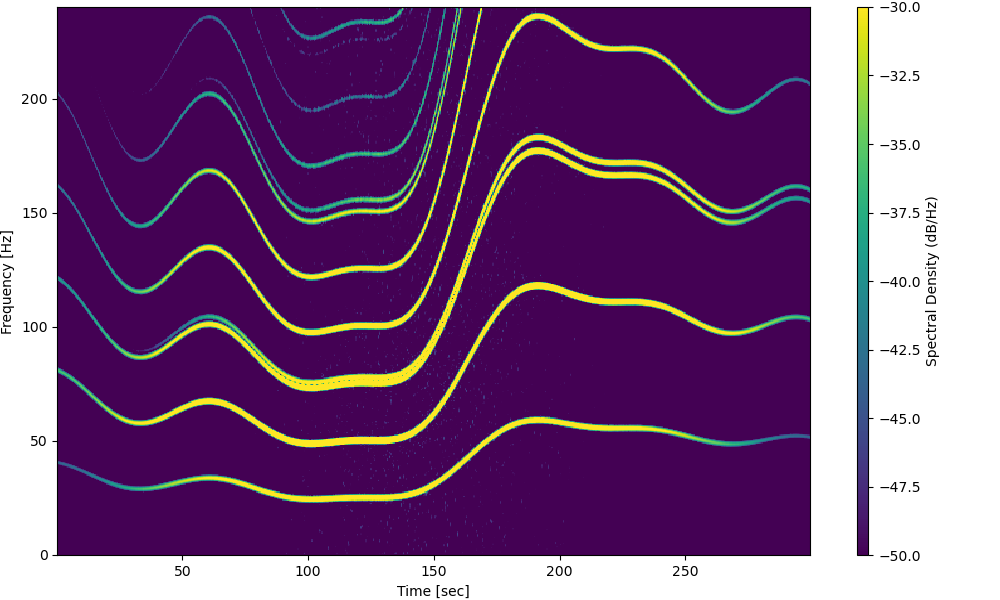

In [40]:
f_axis, t_axis, Sxx = spectrogram(xn,                # Fullt signal
                                  fs,                # Samplingsfrekvens
                                  window = 'hamming', # Vindusfunksjon (rektangulær)
                                  nperseg = fs,     # Vinduslengde
                                  noverlap = fs/2,      # Antall sampler overlapping
                                  nfft = 2*fs,        # Oppløsning på DFT etter zero padding
                                  )

plt.close(1);plt.figure(1, figsize=(10,6))

plt.pcolormesh(t_axis,            # Array med tidsstempel. Produsert av spectrogram()
               f_axis,            # Array med frekvenser. Produsert av spectrogram()
               10*np.log10(Sxx),  # Konvertering av spektrogrammatrise til logaritmisk skala
               vmax =-30,         # Høyeste dB-verdi på fargekartet
               vmin = -50,        # Laveste dB-verdi på fargekartet
               shading='auto'
               );
plt.colorbar(aspect=50, label=r'Spectral Density (dB/Hz)')

#plt.ylim([0, 240]) # Du kan justere på grensene i y-aksen dersom du vil inspisere en spesiell del av plottet
#plt.xlim([0, 15]) # Du kan justere på grensene i x-aksen dersom du vil inspisere en spesiell del av plottet
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)
plt.show()



By now, the inherent tradeoff between frequency resolution and time-domain resolution should be pretty apparent. This is not only something to keep in mind when calculating spectrograms, but also any frequency analysis of non-stationary signals as well spectrum analysis being conducted in "real-time"

## End-of-assignment quiz questions:

The following questions assume a common sampling frequency of $f_s = 480 \text{ samples/sec}$ as in the vibration measurement source file.

### b) 

In the process of creating a spectrogram, you are presented with the following requirement: the time-domain frame width (time duration which corresponds with one single magnitude spectrum "slice") should be precisely $1$ second. Assuming no overlapping or zero padding, what is the window size $N$ you must use?

In [43]:
fs = 480
N_b = fs
# WRITE YOUR CODE IN THIS CELL:

In [44]:
from hashlib import sha1
assert sha1(str(round(float(N_b), 0)).encode('utf-8')+b'c0421').hexdigest() == 'cc13a4fc8b136c250da32fdee39fd202b46c6b83', 'Wrong answer for N_b :('
print('Correct answer for N_b :)')

Correct answer for N_b :)


### c) 
Assuming we now allow $50\%$ overlapping between neighbroing segments. How large might the window size $N$ be now?

In [47]:
N_c = fs * 2
# WRITE YOUR CODE IN THIS CELL:

In [48]:
from hashlib import sha1
assert sha1(str(round(float(N_c), 0)).encode('utf-8')+b'74f3').hexdigest() == '8975b5fb7f9869aaeecfa27a9febe18fe6f852e3', 'Wrong answer for N_c :('
print('Correct answer for N_c :)')

Correct answer for N_c :)


### d) 

Supposing we decided to pad the `N_c` signal samples you found in task **b)** with $1440$ zeroes. What would the resulting resolution bandwidth $\Delta f$ for each DFT segment be?

In [49]:
N_pad_zeros = 1440
RBW = fs/(N_c + N_pad_zeros) 
# WRITE YOUR CODE IN THIS CELL:

In [50]:
from hashlib import sha1
assert sha1(str(round(float(RBW), 2)).encode('utf-8')+b'4999c').hexdigest() == '20351cd3321ee8927cf61727fe4e9d97b98e696c', 'Wrong answer for RBW :('
print('Correct answer for RBW :)')

Correct answer for RBW :)


### e)

Building on the specifications covered in **a)** and **b)**, assume we now also desire a resolution bandwidth $\Delta f = 0.1 \text{ Hz}$. How many zeros must we pad each window with before calculating the DFT?

In [55]:
delta_f = 0.1 #Hz
N = fs/delta_f

N_zeros = N - N_c 
# WRITE YOUR CODE IN THIS CELL:

In [56]:
from hashlib import sha1
assert sha1(str(round(float(N_zeros), 0)).encode('utf-8')+b'aa104').hexdigest() == '63f3eb426cc570ec41c2130e372af96b49292801', 'Wrong answer for N_zeros :('
print('Correct answer for N_zeros :)')

Correct answer for N_zeros :)
